In [1]:
# %matplotlib inline


# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


import importlib
from libs import trades, plots, params
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)

<module 'libs.params' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/params.py'>

In [2]:
import sys
print(sys.executable)

import math
import pandas as pd
from pandas import Timestamp
pd.set_option('display.max_columns', None)

import numpy as np
import glob
import os
import json

import datetime as dt
from datetime import datetime
from pprint import pprint
from collections import OrderedDict

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from IPython.display import display, HTML
import seaborn as sns

from typing import Optional, Dict, Tuple, List, Sequence
from sklearn.preprocessing import StandardScaler

from tqdm.auto import tqdm
tqdm.pandas()        

pd.set_option('display.max_columns', None)


/usr/bin/python


[main] Found existing base CSV: dfs/AAPL_1_base.csv


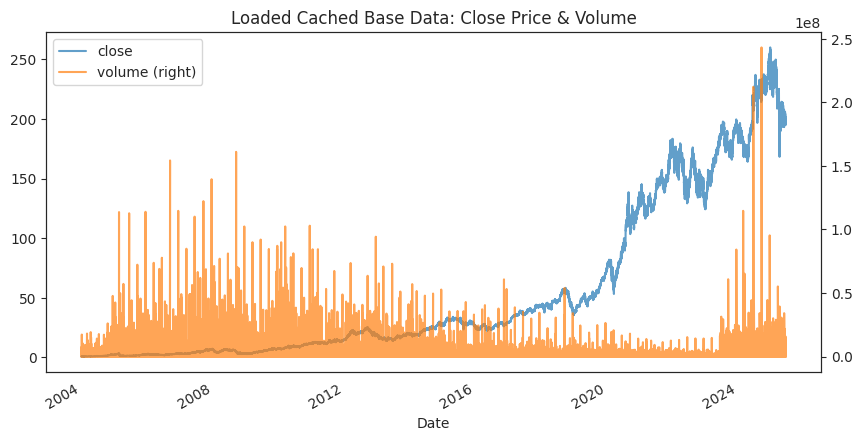

,open,high,low,close,volume,ask,bid
2004-01-02 09:00:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764668,0.763904
2004-01-02 09:01:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764668,0.763904
2004-01-02 09:02:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764668,0.763904
2004-01-02 09:03:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764668,0.763904
2004-01-02 09:04:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764668,0.763904
...,...,...,...,...,...,...,...
2025-06-18 20:56:00,196.680000,196.860000,196.630000,196.815000,385695.0,196.913400,196.716600
2025-06-18 20:57:00,196.810000,196.940000,196.560000,196.675000,460630.0,196.773300,196.576700
2025-06-18 20:58:00,196.675000,196.740000,196.630000,196.670000,525245.0,196.768300,196.571700
2025-06-18 20:59:00,196.680000,196.750000,196.240000,196.240000,2075503.0,196.338100,196.141900


In [3]:
base_csv = params.base_csv

if not params.createCSVbase and os.path.exists(base_csv):
    # -----------------------------------------------------------------
    # 1) Cached file exists → load it, plot it, skip all processing.
    # -----------------------------------------------------------------
    print(f"[main] Found existing base CSV: {base_csv}")
    df = pd.read_csv(base_csv, index_col=0, parse_dates=True)
    plots.plot_close_volume(
        df,
        title="Loaded Cached Base Data: Close Price & Volume"
    )

else:
    # -----------------------------------------------------------------
    # 2) No cached file → do the full split‐adjust and then minute‐grid prep
    # -----------------------------------------------------------------
    print(f"[main] Re-creating base CSV; running process_splits …")
    df_raw = trades.process_splits(
        folder              = params.stocks_folder,
        ticker              = params.ticker,
        bidask_spread_pct   = params.bidask_spread_pct
    )

    # Once‐only minute grid build and interpolation
    print(f"[main] Running prepare_interpolate_data …")
    df = trades.prepare_interpolate_data(
        df                = df_raw,
        sess_premark      = params.sess_premark,
        sess_start        = params.sess_start,
        sess_end          = params.sess_end
    )
    
    # Persist to base CSV and return
    df.to_csv(base_csv)
    print(f"[process_splits] Saved processed data to: {base_csv}")

# df is now guaranteed to be the split‐adjusted, minute‐aligned DataFrame
df


In [4]:
def saveDF_checkDAY(
    df: pd.DataFrame,
    best_optuna_params: Dict
) -> pd.DataFrame:
    """
    1) Slice df to the month in params.month_to_check ("YYYY-MM").
    2) Run the optimized pipeline over that month’s data:
       - The pipeline itself will group and simulate day by day.
       - Plot each day’s trades & equity.
       - Print per-day performance.
    3) If params.createCSVsign:
       • Rerun pipeline on the full df, aggregate & plot.
       • Save the full-run signals CSV.
       • Return the full-run DataFrame.
    4) Otherwise return the month’s concatenated signals/actions DataFrame.
    """
    # 1) Filter to the chosen month
    month_str = params.month_to_check    # e.g. "2023-09"
    print(f"\n=== Running pipeline for month {month_str} ===")

    # mask all rows whose index formatted as "YYYY-MM" equals month_to_check
    df_period = df[df.index.strftime("%Y-%m") == month_str].copy()
    if df_period.empty:
        print("No market data for this month; returning empty DataFrame.")
        return pd.DataFrame()

    # 2) Run pipeline on entire month slice
    result_by_day = trades.run_trading_pipeline(
        df           = df_period,
        col_signal   = "signal",
        col_action   = "signal_action",
        **best_optuna_params
    )
    if not result_by_day:
        print("No trades generated in this period; returning empty DataFrame.")
        return pd.DataFrame()

    # Unpack per-day results for plotting & stats
    month_frames = []
    month_stats  = []
    for day, (df_day, trades_day, perf_day) in result_by_day.items():
        print(f"-------------------------------------------------------------------------------------------------------------------------------------------------")
        plots.plot_trades(
            df                 = df_day,
            col_signal1        = "signal",
            col_signal2        = False,
            col_action         = "signal_action",
            trades             = trades_day,
            buy_threshold      = best_optuna_params["buy_threshold"],
            performance_stats  = perf_day,
            start_plot         = params.sess_start
        )
        for k, v in perf_day.items():
            print(f"  {k}: {v}")

        month_frames.append(df_day)
        month_stats.append(perf_day)

    df_month = pd.concat(month_frames).sort_index()
    plots.aggregate_performance(month_stats, df_month)
    
    # If not saving full-run CSV, just return the month’s results
    if not params.createCSVsign:
        return df_month

    # 3) Full-run backtest (same as before)
    print("\n******************** Running pipeline on full dataset ********************")
    full_results = trades.run_trading_pipeline(
        df           = df,
        col_signal   = "signal",
        col_action   = "signal_action",
        **best_optuna_params
    )

    # Build combined DF & perf list
    daily_frames = [res[0] for res in full_results.values()]
    df_all       = pd.concat(daily_frames).sort_index()
    perf_all     = [res[2] for res in full_results.values()]
    plots.aggregate_performance(perf_all, df_all)

    # Test-period slice & performance
    all_days  = df_all.index.normalize().unique()
    cutoff    = int(len(all_days) * (params.train_prop + params.val_prop))
    test_days = all_days[cutoff:]
    df_test   = df_all[df_all.index.normalize().isin(test_days)]
    perf_test = [
        stats
        for day, (_, _, stats) in full_results.items()
        if pd.Timestamp(day).normalize() in test_days
    ]
    plots.aggregate_performance(perf_test, df_test)

    # Save the full-run signals CSV
    print(f"\nSaving full-run signals to {params.sign_csv} …")
    df_all.to_csv(params.sign_csv)
    print("CSV saved.")

    return df_all


best_optuna_value: 0.5281827777777778
best_optuna_params: {'min_prof_thr': 0.019999841226709288, 'max_down_prop': 2.90149627416334, 'gain_tightening_factor': 16.76426889441275, 'merging_retracement_thr': 0.17682443764531047, 'merging_time_gap_thr': 2.1368577059840685, 'tau_time': 23, 'tau_dur': 144, 'trailing_stop_pct': 0.035875214847538944, 'buy_threshold': 0.2332458716851719, 'beta_sat': 16, 'smoothing_window': 30}

=== Running pipeline for month 2024-06 ===
Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 19/19 [00:00<00:00, 21.91day/s]


-------------------------------------------------------------------------------------------------------------------------------------------------


  Buy & Hold Return ($): 0.586
  Strategy Return ($): 1.872
  Trades Returns ($): [1.366, -0.646, 0.526, 0.627]
-------------------------------------------------------------------------------------------------------------------------------------------------


  Buy & Hold Return ($): -0.964
  Strategy Return ($): -0.853
  Trades Returns ($): [-0.914, 0.721, -0.659]
-------------------------------------------------------------------------------------------------------------------------------------------------


  Buy & Hold Return ($): -0.386
  Strategy Return ($): -0.277
  Trades Returns ($): [0.194, -0.471]
-------------------------------------------------------------------------------------------------------------------------------------------------


  Buy & Hold Return ($): -2.145
  Strategy Return ($): -0.705
  Trades Returns ($): [-0.426, 0.043, -0.25, -0.07]
-------------------------------------------------------------------------------------------------------------------------------------------------


  Buy & Hold Return ($): 1.174
  Strategy Return ($): 1.343
  Trades Returns ($): [0.634, 0.708]
-------------------------------------------------------------------------------------------------------------------------------------------------


  Buy & Hold Return ($): -4.195
  Strategy Return ($): -3.132
  Trades Returns ($): [-0.117, -2.944, -0.137, 0.067]
-------------------------------------------------------------------------------------------------------------------------------------------------


  Buy & Hold Return ($): 12.644
  Strategy Return ($): 12.498
  Trades Returns ($): [10.535, 1.963]
-------------------------------------------------------------------------------------------------------------------------------------------------


  Buy & Hold Return ($): 5.354
  Strategy Return ($): 12.935
  Trades Returns ($): [9.632, 3.302]
-------------------------------------------------------------------------------------------------------------------------------------------------


  Buy & Hold Return ($): -1.215
  Strategy Return ($): 0.496
  Trades Returns ($): [0.749, -1.274, 1.021]
-------------------------------------------------------------------------------------------------------------------------------------------------


  Buy & Hold Return ($): -1.793
  Strategy Return ($): -0.585
  Trades Returns ($): [-0.752, 0.168]
-------------------------------------------------------------------------------------------------------------------------------------------------


  Buy & Hold Return ($): 2.78
  Strategy Return ($): 4.502
  Trades Returns ($): [4.574, -0.072]
-------------------------------------------------------------------------------------------------------------------------------------------------


  Buy & Hold Return ($): -3.736
  Strategy Return ($): -4.084
  Trades Returns ($): [-2.357, -1.564, -0.21, 0.045]
-------------------------------------------------------------------------------------------------------------------------------------------------


  Buy & Hold Return ($): -4.322
  Strategy Return ($): -2.188
  Trades Returns ($): [-1.329, -0.942, 0.411, -0.09, -0.391, 0.151]
-------------------------------------------------------------------------------------------------------------------------------------------------


  Buy & Hold Return ($): -2.859
  Strategy Return ($): -0.54
  Trades Returns ($): [0.008, -0.061, -0.411, -0.079]
-------------------------------------------------------------------------------------------------------------------------------------------------


  Buy & Hold Return ($): 1.192
  Strategy Return ($): 3.544
  Trades Returns ($): [4.721, -0.13, -0.687, -0.359]
-------------------------------------------------------------------------------------------------------------------------------------------------


  Buy & Hold Return ($): -0.87
  Strategy Return ($): 0.377
  Trades Returns ($): [-0.195, 0.571]
-------------------------------------------------------------------------------------------------------------------------------------------------


  Buy & Hold Return ($): 1.553
  Strategy Return ($): 2.558
  Trades Returns ($): [2.627, -0.069]
-------------------------------------------------------------------------------------------------------------------------------------------------


  Buy & Hold Return ($): -1.224
  Strategy Return ($): -1.31
  Trades Returns ($): [-0.834, -0.092, -0.009, -0.375]
-------------------------------------------------------------------------------------------------------------------------------------------------


  Buy & Hold Return ($): -4.788
  Strategy Return ($): -3.844
  Trades Returns ($): [-0.96, -0.444, -0.349, -0.024, -0.154, -1.913]

Overall Summary (2024-06-03 = 193.4167 → 2024-06-28 = 210.5147)

One-time buy&hold gain: 17.098
Buy & Hold – each day ($): -3.214
Strategy Return ($): 22.607
Trades Count: 62
Strategy return per trade: 0.365
Num. trading days: 19
Strategy return per trading day: 1.190


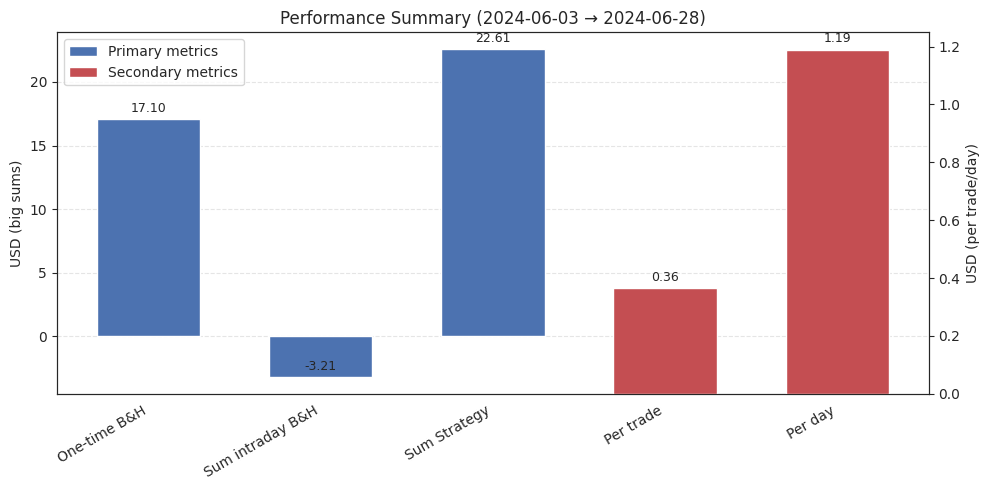

,open,high,low,close,volume,ask,bid,signal_raw,signal,signal_action,Position,Cash,NetValue,Action,TradedAmount,BuyHoldEarning,StrategyEarning,EarningDiff
2024-06-03 09:00:00,192.45,193.14,192.4500,192.5200,3376.0,192.6163,192.4237,0.000108,0.339731,0,0,0.000,0.000,No trade,0,0.000,0.000,0.000
2024-06-03 09:01:00,192.52,192.69,192.5200,192.6000,1028.0,192.6963,192.5037,0.000099,0.348085,0,0,0.000,0.000,No trade,0,0.000,0.000,0.000
2024-06-03 09:02:00,192.60,192.78,192.6000,192.7000,6174.0,192.7964,192.6036,0.000086,0.354721,0,0,0.000,0.000,No trade,0,0.000,0.000,0.000
2024-06-03 09:03:00,192.76,192.78,192.6600,192.7400,2982.0,192.8364,192.6436,0.000082,0.358200,0,0,0.000,0.000,No trade,0,0.000,0.000,0.000
2024-06-03 09:04:00,192.77,193.05,192.7700,193.0500,13024.0,193.1465,192.9535,0.000025,0.362097,0,0,0.000,0.000,No trade,0,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-28 20:56:00,211.03,211.30,210.8200,210.9050,1209248.0,211.0105,210.7995,0.000010,0.106091,0,0,-3.844,-3.844,Hold,0,-4.503,-3.844,0.659
2024-06-28 20:57:00,210.89,211.40,210.6888,211.2373,1114125.0,211.3429,211.1317,0.000000,0.036147,0,0,-3.844,-3.844,Hold,0,-4.171,-3.844,0.327
2024-06-28 20:58:00,211.23,211.55,210.8300,210.9600,1375474.0,211.0655,210.8545,0.000000,0.008218,0,0,-3.844,-3.844,Hold,0,-4.448,-3.844,0.604
2024-06-28 20:59:00,210.97,211.22,210.3000,210.6100,2594034.0,210.7153,210.5047,0.000000,0.008699,0,0,-3.844,-3.844,Hold,0,-4.798,-3.844,0.954


In [5]:
print('best_optuna_value:', params.best_optuna_value)
print('best_optuna_params:', params.best_optuna_params)

df_fin = saveDF_checkDAY(
                        df=df,
                        best_optuna_params=params.best_optuna_params
                        )

df_fin

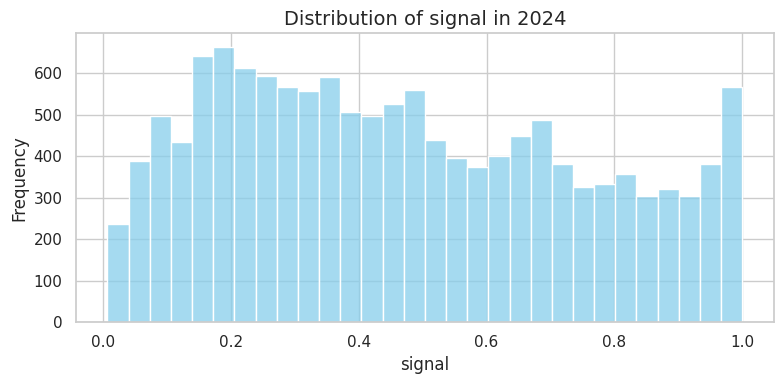

,signal_min,signal_max,signal_mean,signal_median,close_return
2024-06,0.006988,1.0,0.472408,0.442188,0.150215


In [6]:
pd.set_option('display.max_columns', None)

# Group by month
period = df_fin.index.to_period('M')

# Monthly stats for signal
signal_stats = df_fin.groupby(period)['signal'].agg(
    signal_min='min',
    signal_max='max',
    signal_mean='mean',
    signal_median='median'
)

# Monthly close return: (max - min) / min
close_return = df_fin.groupby(period)['close'].agg(
    close_return=lambda x: np.nan if x.min() == 0 else (x.max() - x.min()) / x.min()
)

# Combine into one DataFrame
monthly_stats = signal_stats.join(close_return)


# --------------------------------------------------
# Now plot histograms of signal for each year
# --------------------------------------------------

sns.set(style="whitegrid")
unique_years = sorted(df_fin.index.year.unique())

for y in unique_years:
    subset = df_fin[df_fin.index.year == y]['signal']
    
    plt.figure(figsize=(8, 4))
    sns.histplot(subset, bins=30, kde=False, color="skyblue")
    plt.title(f"Distribution of signal in {y}", fontsize=14)
    plt.xlabel("signal", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.tight_layout()
    plt.show()

monthly_stats
